#Feature Engineering
### Number of Previous Flights
### Percent Previous Delayed
### Prophet Percent Delayed

#Loading all packages and datasets

In [0]:
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.functions import min
from pyspark.sql.functions import col, max
from pyspark.sql.functions import format_string
from pyspark.sql.functions import substring
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import concat
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import lit
from pyspark.sql.functions import to_utc_timestamp
from pyspark.sql.functions import expr
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import instr
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
import random as rnd
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression


from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# data_BASE_DIR = "dbfs:/mnt/mids-w261/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

In [0]:
# # Inspect the Mount's Final Project folder 
# # Please IGNORE dbutils.fs.cp("/mnt/mids-w261/datasets_final_project/stations_data/", "/mnt/mids-w261/datasets_final_project_2022/stations_data/", recurse=True)
# data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

### Init Script and SAS Token

In [0]:
#Initializes blob storage credentials/location
blob_container = "w261-sec4-group2" # The name of your container created in https://portal.azure.com
storage_account = "kdevery" # The name of your Storage account created in https://portal.azure.com
secret_scope = "sec4-group2" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

#Points to SAS token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

### Loading Processed Datasets

In [0]:
display(dbutils.fs.ls(f"{blob_url}"))

path,name,size,modificationTime
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_data/,feature_engineered_data/,0,1668924639000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_data_test/,feature_engineered_data_test/,0,1668924670000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_train_data/,feature_engineered_train_data/,0,1668559613000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data/,merged_cleaned_data/,0,1669494945000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data_test/,merged_cleaned_data_test/,0,1669495012000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data_train/,merged_cleaned_data_train/,0,1669495000000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_data/,merged_data/,0,1669494746000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/number_flights_and_delay_rate/,number_flights_and_delay_rate/,0,1669798919000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/pagerank_scores/,pagerank_scores/,0,1669854087000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/premerge_airline_data/,premerge_airline_data/,0,1669567605000


In [0]:
# Read in training and test data

train_df = spark.read.parquet(f"{blob_url}/feature_engineered_data")
test_df = spark.read.parquet(f"{blob_url}/feature_engineered_data_test")

# number of flights per prior_day for origin and destination

In [0]:
# Join sum of number of flights and delays for a given airport to the date 2 days in the future

#reading from blob. 
airline_data_df= spark.read.parquet(f"{blob_url}/premerge_airline_data")

#getting rid of duplicates
# print(f' count before dropping duplicates: {airline_data_df.count()}') 
airline_data_df = airline_data_df.dropDuplicates()
# print(f' count after dropping duplicates: {airline_data_df.count()}')

#creating the new feature for total number of flights per prior_day for Origin and Destination Airports. 
airline_data_df = airline_data_df.withColumn("id", f.monotonically_increasing_id())


from pyspark.sql.functions import to_timestamp

#for each origin
origin_per_day = airline_data_df.select(f.col("FL_DATE").alias("FL_DATE_origin"), 
                                             f.col("ORIGIN").alias('ORIGIN2'), 'id')\
                                              .groupby('FL_DATE_origin', "ORIGIN2")\
                                              .agg(f.count("id").alias("origin_flight_per_day"))
 

origin_per_day = airline_data_df.select(f.col("FL_DATE").alias("FL_DATE_origin"), 
                                             f.col("ORIGIN").alias('ORIGIN2'), 'id', 'DEP_DEL15')\
                                              .groupby('FL_DATE_origin', "ORIGIN2")\
                                              .agg(f.count("id").alias("origin_flight_per_day"), f.sum('DEP_DEL15').alias('origin_delays_per_day'))
 
origin_per_day1 = origin_per_day.select('ORIGIN2','origin_flight_per_day', 'origin_delays_per_day', col("FL_DATE_origin"), 
                                        f.to_date(col("FL_DATE_origin"), "yyy-MM-dd").alias("date_origin"))
 
origin_per_day2 = origin_per_day1.select('ORIGIN2','origin_flight_per_day','origin_delays_per_day','FL_DATE_origin',
                                         col("date_origin"),f.date_add(col("date_origin"),2).alias("origin_date_plus_2"))
 
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
origin_per_day3 = origin_per_day2.filter(origin_per_day2.origin_date_plus_2 != '2021-01-01')



#for each destination
destination_per_day = airline_data_df.select(f.col("FL_DATE").alias("FL_DATE_Dest"),
                                              f.col("DEST").alias('DEST2'), 'id', 'DEP_DEL15')\
                                      .groupby('FL_DATE_Dest', "DEST2")\
                                      .agg(f.count("id").alias("dest_flight_per_day"), f.sum('DEP_DEL15').alias('dest_delays_per_day'))

destination_per_day1 = destination_per_day.select('DEST2','dest_flight_per_day','dest_delays_per_day', col('FL_DATE_Dest'), 
                                        f.to_date(col("FL_DATE_Dest"), "yyy-MM-dd").alias("date_dest"))
 
destination_per_day2 = destination_per_day1.select('DEST2','dest_flight_per_day','dest_delays_per_day','FL_DATE_Dest',
                                         col("date_dest"),f.date_add(col("date_dest"),2).alias("dest_date_plus_2"))
 
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
destination_per_day3 = destination_per_day2.filter(destination_per_day2.dest_date_plus_2 != '2021-01-01')


# join back to the original data. 
flight_origin1 =airline_data_df.join(origin_per_day3,
                                        (airline_data_df.FL_DATE == origin_per_day3.origin_date_plus_2) & 
                                        (airline_data_df.ORIGIN == origin_per_day3.ORIGIN2), how='left') \
                                        .drop('ORIGIN2', 'origin_date_plus_2','FL_DATE_origin','date_origin','id')
 
airline_df_plus_2day = flight_origin1.join(destination_per_day3, 
                                        (flight_origin1.FL_DATE == destination_per_day3.dest_date_plus_2) & 
                                        (flight_origin1.DEST == destination_per_day3.DEST2), how='left') \
                                .drop('DEST2', 'dest_date_plus_2','FL_DATE_Dest','date_dest')
 
display(airline_df_plus_2day)

YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,DEP_DEL15,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,Origin_IATA,origin_Timezone,origin_TZ,dest_IATA,dest_Timezone,dest_TZ,Date_Time_sched_dep,Date_Time_sched_arrival,two_hrs_pre_flight,two_hrs_pre_flight_utc,Date_Time_sched_dep_utc,Date_Time_sched_arrival_utc,origin_flight_per_day,origin_delays_per_day,dest_flight_per_day,dest_delays_per_day
2015,1,1,1,4,2015-01-01,EV,20366,EV,N16976,ORD,ELM,2100,2347,-26.0,0.0,107.0,566.0,3,ORD,-6,America/Chicago,ELM,-5,America/New_York,2015-01-01 21:00:00,2015-01-01 23:00:00,2015-01-01 19:00:00,2015-01-02T01:00:00.000+0000,2015-01-02T03:00:00.000+0000,2015-01-02T04:00:00.000+0000,null,null,null,null
2015,1,1,1,4,2015-01-01,EV,20366,EV,N16571,ORD,GRB,2115,2211,-9.0,0.0,56.0,173.0,1,ORD,-6,America/Chicago,GRB,-6,America/Chicago,2015-01-01 21:00:00,2015-01-01 22:00:00,2015-01-01 19:00:00,2015-01-02T01:00:00.000+0000,2015-01-02T03:00:00.000+0000,2015-01-02T04:00:00.000+0000,null,null,null,null
2015,1,1,1,4,2015-01-01,AA,19805,AA,N3KFAA,ORD,LAX,1935,2210,-10.0,0.0,275.0,1744.0,7,ORD,-6,America/Chicago,LAX,-8,America/Los_Angeles,2015-01-01 19:00:00,2015-01-01 22:00:00,2015-01-01 17:00:00,2015-01-01T23:00:00.000+0000,2015-01-02T01:00:00.000+0000,2015-01-02T06:00:00.000+0000,null,null,null,null
2015,1,1,1,4,2015-01-01,AA,19805,AA,N3FFAA,ORD,LAX,1140,1405,-26.0,0.0,265.0,1744.0,7,ORD,-6,America/Chicago,LAX,-8,America/Los_Angeles,2015-01-01 11:00:00,2015-01-01 14:00:00,2015-01-01 09:00:00,2015-01-01T15:00:00.000+0000,2015-01-01T17:00:00.000+0000,2015-01-01T22:00:00.000+0000,null,null,null,null
2015,1,1,1,4,2015-01-01,AA,19805,AA,N3LPAA,ORD,SNA,1935,2155,-22.0,0.0,260.0,1726.0,7,ORD,-6,America/Chicago,SNA,-8,America/Los_Angeles,2015-01-01 19:00:00,2015-01-01 21:00:00,2015-01-01 17:00:00,2015-01-01T23:00:00.000+0000,2015-01-02T01:00:00.000+0000,2015-01-02T05:00:00.000+0000,null,null,null,null
2015,1,1,1,4,2015-01-01,AA,19805,AA,N3HMAA,ORD,SNA,1350,1610,-10.0,0.0,260.0,1726.0,7,ORD,-6,America/Chicago,SNA,-8,America/Los_Angeles,2015-01-01 13:00:00,2015-01-01 16:00:00,2015-01-01 11:00:00,2015-01-01T17:00:00.000+0000,2015-01-01T19:00:00.000+0000,2015-01-02T00:00:00.000+0000,null,null,null,null
2015,1,1,3,6,2015-01-03,EV,20366,EV,N15983,ORD,IND,0727,0932,20.0,0.0,65.0,177.0,1,ORD,-6,America/Chicago,IND,-5,America/New_York,2015-01-03 07:00:00,2015-01-03 09:00:00,2015-01-03 05:00:00,2015-01-03T11:00:00.000+0000,2015-01-03T13:00:00.000+0000,2015-01-03T14:00:00.000+0000,684,157.0,65,15.0
2015,1,1,3,6,2015-01-03,AA,19805,AA,N564AA,ORD,STL,1845,1950,69.0,1.0,65.0,258.0,2,ORD,-6,America/Chicago,STL,-6,America/Chicago,2015-01-03 18:00:00,2015-01-03 19:00:00,2015-01-03 16:00:00,2015-01-03T22:00:00.000+0000,2015-01-04T00:00:00.000+0000,2015-01-04T01:00:00.000+0000,684,157.0,104,31.0
2015,1,1,4,7,2015-01-04,AA,19805,AA,N578AA,ORD,DFW,2115,2340,17.0,1.0,145.0,802.0,4,ORD,-6,America/Chicago,DFW,-6,America/Chicago,2015-01-04 21:00:00,2015-01-04 23:00:00,2015-01-04 19:00:00,2015-01-05T01:00:00.000+0000,2015-01-05T03:00:00.000+0000,2015-01-05T05:00:00.000+0000,806,189.0,757,298.0
2015,1,1,4,7,2015-01-04,AA,19805,AA,N549AA,ORD,DFW,0730,1000,30.0,1.0,150.0,802.0,4,ORD,-6,America/Chicago,DFW,-6,America/Chicago,2015-01-04 07:00:00,2015-01-04 10:00:00,2015-01-04 05:00:00,2015-01-04T11:00:00.000+0000,2015-01-04T13:00:00.000+0000,2015-01-04T16:00:00.000+0000,806,189.0,757,298.0


In [0]:
# airline_df_plus_1day = airline_df_plus_1day.withColumn('origin_flight_per_day', airline_df_plus_1day.origin_flight_per_day.cast('double')) \
#                                           .withColumn('origin_delays_per_day', airline_df_plus_1day.origin_delays_per_day.cast('double')) \
#                                           .withColumn('dest_flight_per_day', airline_df_plus_1day.dest_flight_per_day.cast('double')) \
#                                           .withColumn('dest_delays_per_day', airline_df_plus_1day.dest_delays_per_day.cast('double'))

#airline_df_plus_1day.printSchema()

airline_df_plus_2day_delr = airline_df_plus_2day.withColumn('origin_percent_delayed', f.col('origin_delays_per_day') / f.col('origin_flight_per_day')) \
                                                .withColumn('dest_percent_delayed', f.col('dest_delays_per_day') / f.col('dest_flight_per_day')).cache()

In [0]:
display(airline_df_plus_2day_delr)

YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,DEP_DEL15,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,Origin_IATA,origin_Timezone,origin_TZ,dest_IATA,dest_Timezone,dest_TZ,Date_Time_sched_dep,Date_Time_sched_arrival,two_hrs_pre_flight,two_hrs_pre_flight_utc,Date_Time_sched_dep_utc,Date_Time_sched_arrival_utc,origin_flight_per_day,origin_delays_per_day,dest_flight_per_day,dest_delays_per_day,origin_percent_delayed,dest_percent_delayed
2015,1,1,3,6,2015-01-03,OO,20304,OO,N947SW,DEN,ELP,0808,1000,3.0,1.0,112.0,563.0,3,DEN,-7,America/Denver,ELP,-7,America/Denver,2015-01-03 08:00:00,2015-01-03 10:00:00,2015-01-03 06:00:00,2015-01-03T13:00:00.000+0000,2015-01-03T15:00:00.000+0000,2015-01-03T17:00:00.000+0000,574,318.0,35,14.0,0.554006968641115,0.4
2015,1,1,3,6,2015-01-03,OO,20304,OO,N918SW,DEN,ELP,1358,1546,9.0,0.0,108.0,563.0,3,DEN,-7,America/Denver,ELP,-7,America/Denver,2015-01-03 13:00:00,2015-01-03 15:00:00,2015-01-03 11:00:00,2015-01-03T18:00:00.000+0000,2015-01-03T20:00:00.000+0000,2015-01-03T22:00:00.000+0000,574,318.0,35,14.0,0.554006968641115,0.4
2015,1,1,3,6,2015-01-03,EV,20366,EV,N16178,DEN,ELP,2157,2345,-9.0,0.0,108.0,563.0,3,DEN,-7,America/Denver,ELP,-7,America/Denver,2015-01-03 21:00:00,2015-01-03 23:00:00,2015-01-03 19:00:00,2015-01-04T02:00:00.000+0000,2015-01-04T04:00:00.000+0000,2015-01-04T06:00:00.000+0000,574,318.0,35,14.0,0.554006968641115,0.4
2015,1,1,3,6,2015-01-03,DL,19790,DL,N908DE,ATL,ELP,1050,1232,-19.0,0.0,222.0,1282.0,6,ATL,-5,America/New_York,ELP,-7,America/Denver,2015-01-03 10:00:00,2015-01-03 12:00:00,2015-01-03 08:00:00,2015-01-03T13:00:00.000+0000,2015-01-03T15:00:00.000+0000,2015-01-03T19:00:00.000+0000,738,83.0,35,14.0,0.11246612466124661,0.4
2015,1,1,3,6,2015-01-03,DL,19790,DL,N908DE,ATL,ELP,1910,2052,17.0,1.0,222.0,1282.0,6,ATL,-5,America/New_York,ELP,-7,America/Denver,2015-01-03 19:00:00,2015-01-03 20:00:00,2015-01-03 17:00:00,2015-01-03T22:00:00.000+0000,2015-01-04T00:00:00.000+0000,2015-01-04T03:00:00.000+0000,738,83.0,35,14.0,0.11246612466124661,0.4
2015,1,1,3,6,2015-01-03,WN,19393,WN,N700GS,LAX,ELP,1835,2120,42.0,1.0,105.0,715.0,3,LAX,-8,America/Los_Angeles,ELP,-7,America/Denver,2015-01-03 18:00:00,2015-01-03 21:00:00,2015-01-03 16:00:00,2015-01-04T00:00:00.000+0000,2015-01-04T02:00:00.000+0000,2015-01-04T04:00:00.000+0000,553,115.0,35,14.0,0.20795660036166366,0.4
2015,1,1,3,6,2015-01-03,OO,20304,OO,N863AS,LAX,ELP,0835,1130,1.0,0.0,115.0,715.0,3,LAX,-8,America/Los_Angeles,ELP,-7,America/Denver,2015-01-03 08:00:00,2015-01-03 11:00:00,2015-01-03 06:00:00,2015-01-03T14:00:00.000+0000,2015-01-03T16:00:00.000+0000,2015-01-03T18:00:00.000+0000,553,115.0,35,14.0,0.20795660036166366,0.4
2015,1,1,3,6,2015-01-03,WN,19393,WN,N7812G,LAX,ELP,1130,1415,21.0,0.0,105.0,715.0,3,LAX,-8,America/Los_Angeles,ELP,-7,America/Denver,2015-01-03 11:00:00,2015-01-03 14:00:00,2015-01-03 09:00:00,2015-01-03T17:00:00.000+0000,2015-01-03T19:00:00.000+0000,2015-01-03T21:00:00.000+0000,553,115.0,35,14.0,0.20795660036166366,0.4
2015,1,1,3,6,2015-01-03,MQ,20398,MQ,N507MQ,ORD,ELP,1025,1243,3.0,0.0,198.0,1236.0,5,ORD,-6,America/Chicago,ELP,-7,America/Denver,2015-01-03 10:00:00,2015-01-03 12:00:00,2015-01-03 08:00:00,2015-01-03T14:00:00.000+0000,2015-01-03T16:00:00.000+0000,2015-01-03T19:00:00.000+0000,684,157.0,35,14.0,0.22953216374269006,0.4
2015,1,1,3,6,2015-01-03,MQ,20398,MQ,N537MQ,ORD,ELP,2120,2338,59.0,1.0,198.0,1236.0,5,ORD,-6,America/Chicago,ELP,-7,America/Denver,2015-01-03 21:00:00,2015-01-03 23:00:00,2015-01-03 19:00:00,2015-01-04T01:00:00.000+0000,2015-01-04T03:00:00.000+0000,2015-01-04T06:00:00.000+0000,684,157.0,35,14.0,0.22953216374269006,0.4


# Prophet on Percent Delayed Flights

In [0]:
# create list of airports
airports = airline_df_plus_2day_delr.select('ORIGIN').distinct().toPandas()
airports_list = airports['ORIGIN'].tolist()
len(airports_list)

Out[10]: 388

In [0]:
airports_list.remove('ENV')
airports_list.remove('EFD')
airports_list.remove('TKI')
airports_list.remove('YNG')
airports_list.remove('CDB')
airports_list.remove('ADK')
airports_list.remove('OWB')
airports_list.remove('BFM')
# airports_list.remove('FOD')
# airports_list.remove('DDC')
# airports_list.remove('VCT')
len(airports_list)

Out[11]: 380

In [0]:
airline_prophet_df = airline_df_plus_2day_delr.filter(airline_df_plus_2day_delr['YEAR'] < 2022) \
                                              .select('ORIGIN', 'FL_DATE', 'origin_percent_delayed') \
                                              .withColumnRenamed('FL_DATE', 'ds') \
                                              .withColumnRenamed('origin_percent_delayed', 'y') \
                                              .dropDuplicates().sort('ORIGIN', 'ds').cache()

airline_prophet_df = airline_prophet_df.repartition('ORIGIN')

display(airline_prophet_df)

ORIGIN,ds,y
DRT,2018-11-04,null
DRT,2018-11-05,null
DRT,2018-11-06,1.0
DRT,2018-11-07,0.0
DRT,2018-11-08,0.0
DRT,2018-11-09,0.5
DRT,2018-11-10,0.5
DRT,2018-11-11,0.5
DRT,2018-11-12,0.0
DRT,2018-11-13,0.0


In [0]:
null_df = airline_prophet_df.groupBy('ORIGIN').agg(f.count(f.col('y').isNotNull().alias('valid_points'))).sort('ORIGIN')
display(null_df)

ORIGIN,count((y IS NOT NULL) AS valid_points)
ABE,2547
ABI,2012
ABQ,2557
ABR,2552
ABY,2407
ACK,1098
ACT,2271
ACV,2551
ACY,2547
ADK,691


In [0]:
#Custom Holidays

c_holidays = pd.DataFrame({
  'holiday': 'travel',
  'ds': pd.to_datetime(['2015-1-1','2015-1-2','2015-1-19', '2015-5-25','2015-7-3', '2015-9-7','2015-10-12','2015-11-25','2015-11-26','2015-11-27','2015-12-24','2015-12-25','2015-12-26','2016-1-1', '2016-1-2','2016-1-18','2016-5-30','2016-7-4','2016-9-5','2016-11-24','2016-11-23','2016-11-24','2016-11-25',
                                        '2016-12-25','2016-12-26','2016-12-27',
                                        '2017-1-2','2017-1-3','2017-1-16','2017-5-29','2017-7-4',
                                        '2017-9-4','2017-11-22','2017-11-23','2017-11-24',
                                        '2017-12-24','2017-12-25','2017-12-26',
                                        '2018-1-1','2018-1-2','2018-1-15','2018-5-28','2018-7-4',
                                        '2018-9-3','2018-11-21','2018-11-22','2018-11-23',
                                        '2018-12-24','2018-12-25','2018-12-26',
                                        '2019-1-1','2019-1-2','2019-1-21','2019-5-27','2019-7-4',
                                        '2019-9-2','2019-11-27','2019-11-28','2019-11-29',
                                        '2019-12-24','2019-12-25','2019-12-26',
                                        '2020-1-1','2020-1-2','2020-1-20','2020-5-25','2020-7-3',
                                        '2020-9-7','2020-11-25','2020-11-26','2020-11-27',
                                        '2020-12-24','2020-12-25','2020-12-26']),
  'lower_window': 0,
  'upper_window': 1,
})

c_holidays['ds_upper']  = c_holidays['ds']

c_holidays

,holiday,ds,lower_window,upper_window,ds_upper
0,travel,2015-01-01,0,1,2015-01-01
1,travel,2015-01-02,0,1,2015-01-02
2,travel,2015-01-19,0,1,2015-01-19
3,travel,2015-05-25,0,1,2015-05-25
4,travel,2015-07-03,0,1,2015-07-03
...,...,...,...,...,...
69,travel,2020-11-26,0,1,2020-11-26
70,travel,2020-11-27,0,1,2020-11-27
71,travel,2020-12-24,0,1,2020-12-24
72,travel,2020-12-25,0,1,2020-12-25


In [0]:
#Covid Lockdowns

lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [0]:
holidays = pd.concat([c_holidays, lockdowns])
holidays

,holiday,ds,lower_window,upper_window,ds_upper
0,travel,2015-01-01,0,1,2015-01-01
1,travel,2015-01-02,0,1,2015-01-02
2,travel,2015-01-19,0,1,2015-01-19
3,travel,2015-05-25,0,1,2015-05-25
4,travel,2015-07-03,0,1,2015-07-03
...,...,...,...,...,...
73,travel,2020-12-26,0,1,2020-12-26
0,lockdown_1,2020-03-21,0,77,2020-06-06
1,lockdown_2,2020-07-09,0,110,2020-10-27
2,lockdown_3,2021-02-13,0,4,2021-02-17


In [0]:
from prophet import Prophet

prophet_df = pd.DataFrame()

for air in airports_list:
  p_set = airline_prophet_df.filter(airline_prophet_df.ORIGIN == air)

  p_set_df = p_set.toPandas()
  
  model = Prophet(holidays = holidays, 
                  weekly_seasonality = True,
                  yearly_seasonality = True,
                  growth='linear')

  print(air)
  model.fit(p_set_df)

  #set periods to a large number to see window of uncertainty grow
  future_pd = model.make_future_dataframe(
      periods=200,
      include_history=True)

  # predict over the dataset
  forecast_pd = model.predict(future_pd)
  
  forecast_pd['IATA'] = air
  
  prophet_df = pd.concat([prophet_df, forecast_pd])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
BGM
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
PSE
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INL
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DLG
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
MSY
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
PPG
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
GEG
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DRT
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
SNA
INFO:prophet:Disabling daily seasonality. Run prophet with daily

In [0]:
prophet_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,IATA
0,2015-02-02,0.122540,-0.166499,0.466215,0.122540,0.122540,0.018161,0.018161,0.018161,0.0,...,-0.028204,-0.028204,0.046365,0.046365,0.046365,0.0,0.0,0.0,0.140701,BGM
1,2015-02-03,0.122565,-0.158927,0.484025,0.122565,0.122565,0.039142,0.039142,0.039142,0.0,...,-0.011970,-0.011970,0.051113,0.051113,0.051113,0.0,0.0,0.0,0.161707,BGM
2,2015-02-04,0.122589,-0.091914,0.503885,0.122589,0.122589,0.076702,0.076702,0.076702,0.0,...,0.020420,0.020420,0.056282,0.056282,0.056282,0.0,0.0,0.0,0.199291,BGM
3,2015-02-05,0.122614,-0.123669,0.487930,0.122614,0.122614,0.071606,0.071606,0.071606,0.0,...,0.009832,0.009832,0.061774,0.061774,0.061774,0.0,0.0,0.0,0.194220,BGM
4,2015-02-06,0.122639,-0.134521,0.509535,0.122639,0.122639,0.054800,0.054800,0.054800,0.0,...,-0.012679,-0.012679,0.067480,0.067480,0.067480,0.0,0.0,0.0,0.177440,BGM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2022-07-15,-18.429741,-18.928400,-18.426365,-18.429744,-18.429738,-0.251049,-0.251049,-0.251049,0.0,...,0.508708,0.508708,-0.759758,-0.759758,-0.759758,0.0,0.0,0.0,-18.680790,BIH
209,2022-07-16,-18.519438,-19.867389,-19.353592,-18.519441,-18.519436,-1.105810,-1.105810,-1.105810,0.0,...,0.047807,0.047807,-1.153617,-1.153617,-1.153617,0.0,0.0,0.0,-19.625248,BIH
210,2022-07-17,-18.609136,-20.421440,-19.907558,-18.609139,-18.609133,-1.546335,-1.546335,-1.546335,0.0,...,-0.031169,-0.031169,-1.515166,-1.515166,-1.515166,0.0,0.0,0.0,-20.155471,BIH
211,2022-07-18,-18.698833,-20.535731,-20.029715,-18.698836,-18.698831,-1.589331,-1.589331,-1.589331,0.0,...,0.243581,0.243581,-1.832912,-1.832912,-1.832912,0.0,0.0,0.0,-20.288164,BIH


In [0]:
prophet_spark_df=spark.createDataFrame(prophet_df) 

# Save to Blob

In [0]:
# #Checkpoint Airlines Dataset before join
prophet_spark_df.write.mode("overwrite").parquet(f"{blob_url}/prophet_delay_rate")

In [0]:
airline_df_plus_2day_delr.write.mode("overwrite").parquet(f"{blob_url}/number_flights_and_delay_rate")# airline_df_plus_1day_delr.write.mode("overwrite").parquet(f"{blob_url}/number_flights_and_delay_rate")

# Prophet Example for Report Viz

In [0]:
# for report visualization

from prophet import Prophet

p_set = airline_prophet_df.filter(airline_prophet_df.ORIGIN == 'DFW')

p_set_df = p_set.toPandas()
  
model = Prophet(holidays = holidays,
                weekly_seasonality = True,
                yearly_seasonality = True,
                growth='linear')

model.fit(p_set_df)

  #set periods to a large number to see window of uncertainty grow
future_pd = model.make_future_dataframe(
      periods=100,
      include_history=True)

  # predict over the dataset
forecast_pd = model.predict(future_pd)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


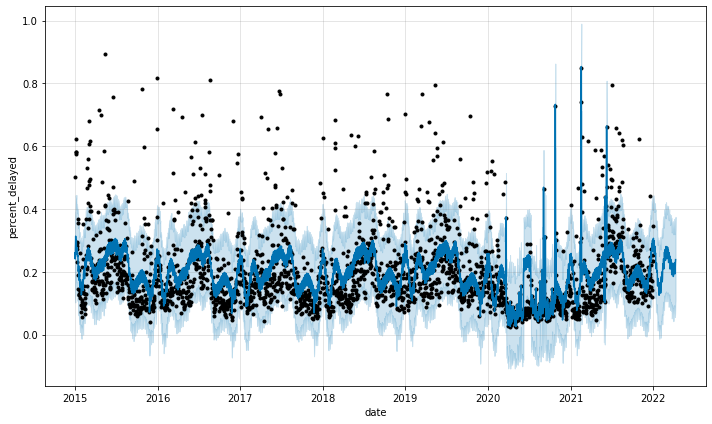

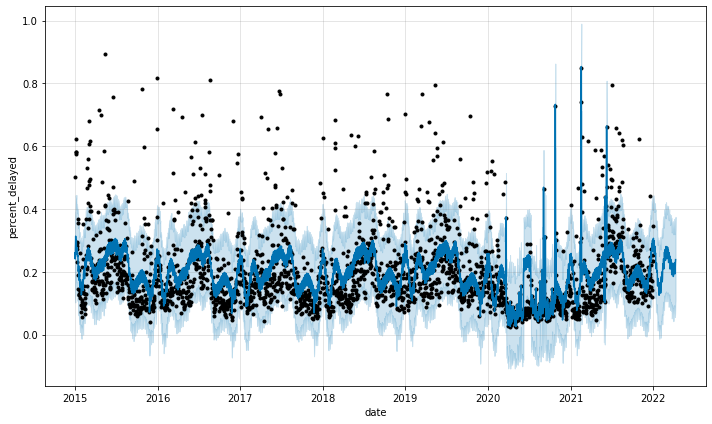

In [0]:
pd.plotting.register_matplotlib_converters()

predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='percent_delayed')
display(predict_fig)

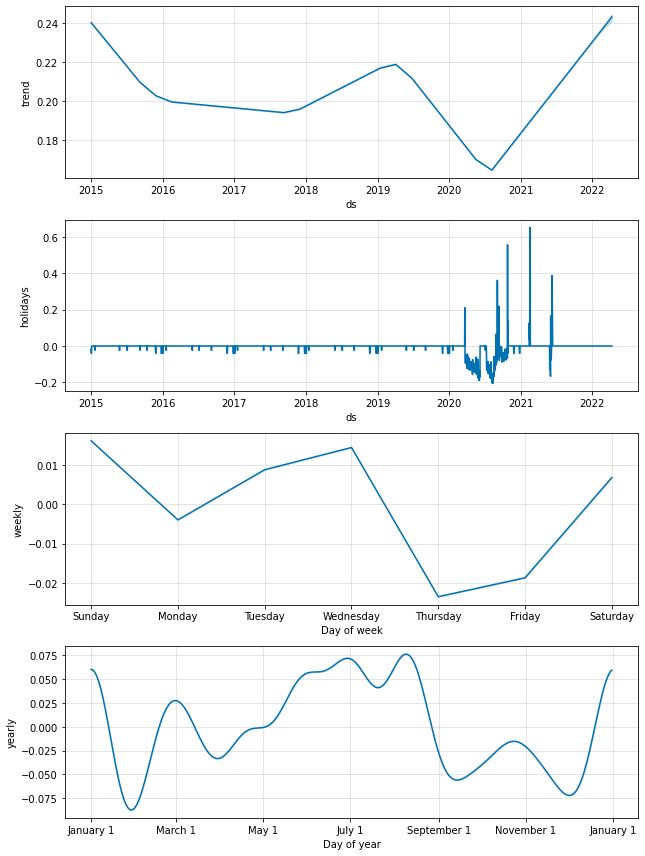

In [0]:
display(figures = model.plot_components(forecast_pd))